In [ ]:
%reload_ext autoreload
%autoreload 2

import os
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import s3fs
import seaborn as sns
from hydra import compose, core, initialize
from IPython.display import display
from joblib import dump
from omegaconf import OmegaConf
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join("..")))
from src.plot_utils import plot_confusion_matrix, plot_violin_plots

## Hydra

In [2]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base="1.2", config_path="../src/config", job_name="clustering")
config = OmegaConf.to_container(compose(config_name="main"), resolve=True)
config

{'s3_bucket': 'yang-ml-sagemaker',
 's3_key': 'tenant-experience',
 'model_dir': '/opt/ml/model',
 'output_path': 's3://yang-ml-sagemaker/tenant-experience/models',
 'code_location': 's3://yang-ml-sagemaker/tenant-experience/code',
 'volume_size': 30,
 'py_version': 'py3',
 'use_spot_instances': True,
 'max_run': 86400,
 'max_retry_attempts': 2,
 'checkpoint_s3_uri': 's3://yang-ml-sagemaker/tenant-experience/checkpoints',
 'src_dir_path': '/home/ec2-user/SageMaker/tenant-experience/src',
 'notebook_dir_path': '/home/ec2-user/SageMaker/tenant-experience/notebooks',
 'stack_name': 'optuna-stack'}

## Input Data

In [3]:
s3_data_path = f"s3://{config['s3_bucket']}/{config['s3_key']}/input-data/cluster/tenant_data.parquet"

data = pl.read_parquet(s3_data_path)

data

household_id,work_order_count,escalation_count,total_maintenance_tickets,mean_first_response_hr,mean_full_resolution_hr,total_tickets,answer_rate,outbound_call_count,zd_positive_rate,zd_negative_rate
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""U00000052""",5.049407,0.0,2.164032,7.845455,29.825758,5.049407,1.0,0.721344,0.0,0.0
"""U00000080""",7.934783,0.0,5.049407,1.216667,28.598374,15.148221,0.540541,11.541502,0.035714,0.0
"""U0000008D""",0.721344,0.0,1.442688,1.35,108.925,3.606719,1.0,1.442688,0.0,0.0
"""U00000096""",0.0,0.0,1.442688,2.34,30.948889,6.492095,1.0,2.164032,0.0,0.0
"""U000000A1""",7.213439,0.0,0.0,15.742308,25.578205,7.934783,1.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…
"""U0001671D""",20.56338,0.0,7.711268,2.495238,19.987302,38.556338,1.0,7.711268,0.055556,0.0
"""U00016724""",35.0,5.0,12.5,10.300758,62.044444,20.0,0.866667,15.0,0.0,0.0
"""U0001672E""",12.762238,0.0,2.552448,1.529412,90.928431,35.734266,1.0,2.552448,0.066667,0.0


In [4]:
numerical_data = data.select(
    [
        pl.col(column)
        for column in data.columns
        if data.schema[column] in [pl.Float64, pl.Int64]
    ]
)

numerical_data

work_order_count,escalation_count,total_maintenance_tickets,mean_first_response_hr,mean_full_resolution_hr,total_tickets,answer_rate,outbound_call_count,zd_positive_rate,zd_negative_rate
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
5.049407,0.0,2.164032,7.845455,29.825758,5.049407,1.0,0.721344,0.0,0.0
7.934783,0.0,5.049407,1.216667,28.598374,15.148221,0.540541,11.541502,0.035714,0.0
0.721344,0.0,1.442688,1.35,108.925,3.606719,1.0,1.442688,0.0,0.0
0.0,0.0,1.442688,2.34,30.948889,6.492095,1.0,2.164032,0.0,0.0
7.213439,0.0,0.0,15.742308,25.578205,7.934783,1.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…
20.56338,0.0,7.711268,2.495238,19.987302,38.556338,1.0,7.711268,0.055556,0.0
35.0,5.0,12.5,10.300758,62.044444,20.0,0.866667,15.0,0.0,0.0
12.762238,0.0,2.552448,1.529412,90.928431,35.734266,1.0,2.552448,0.066667,0.0


## Visualizations

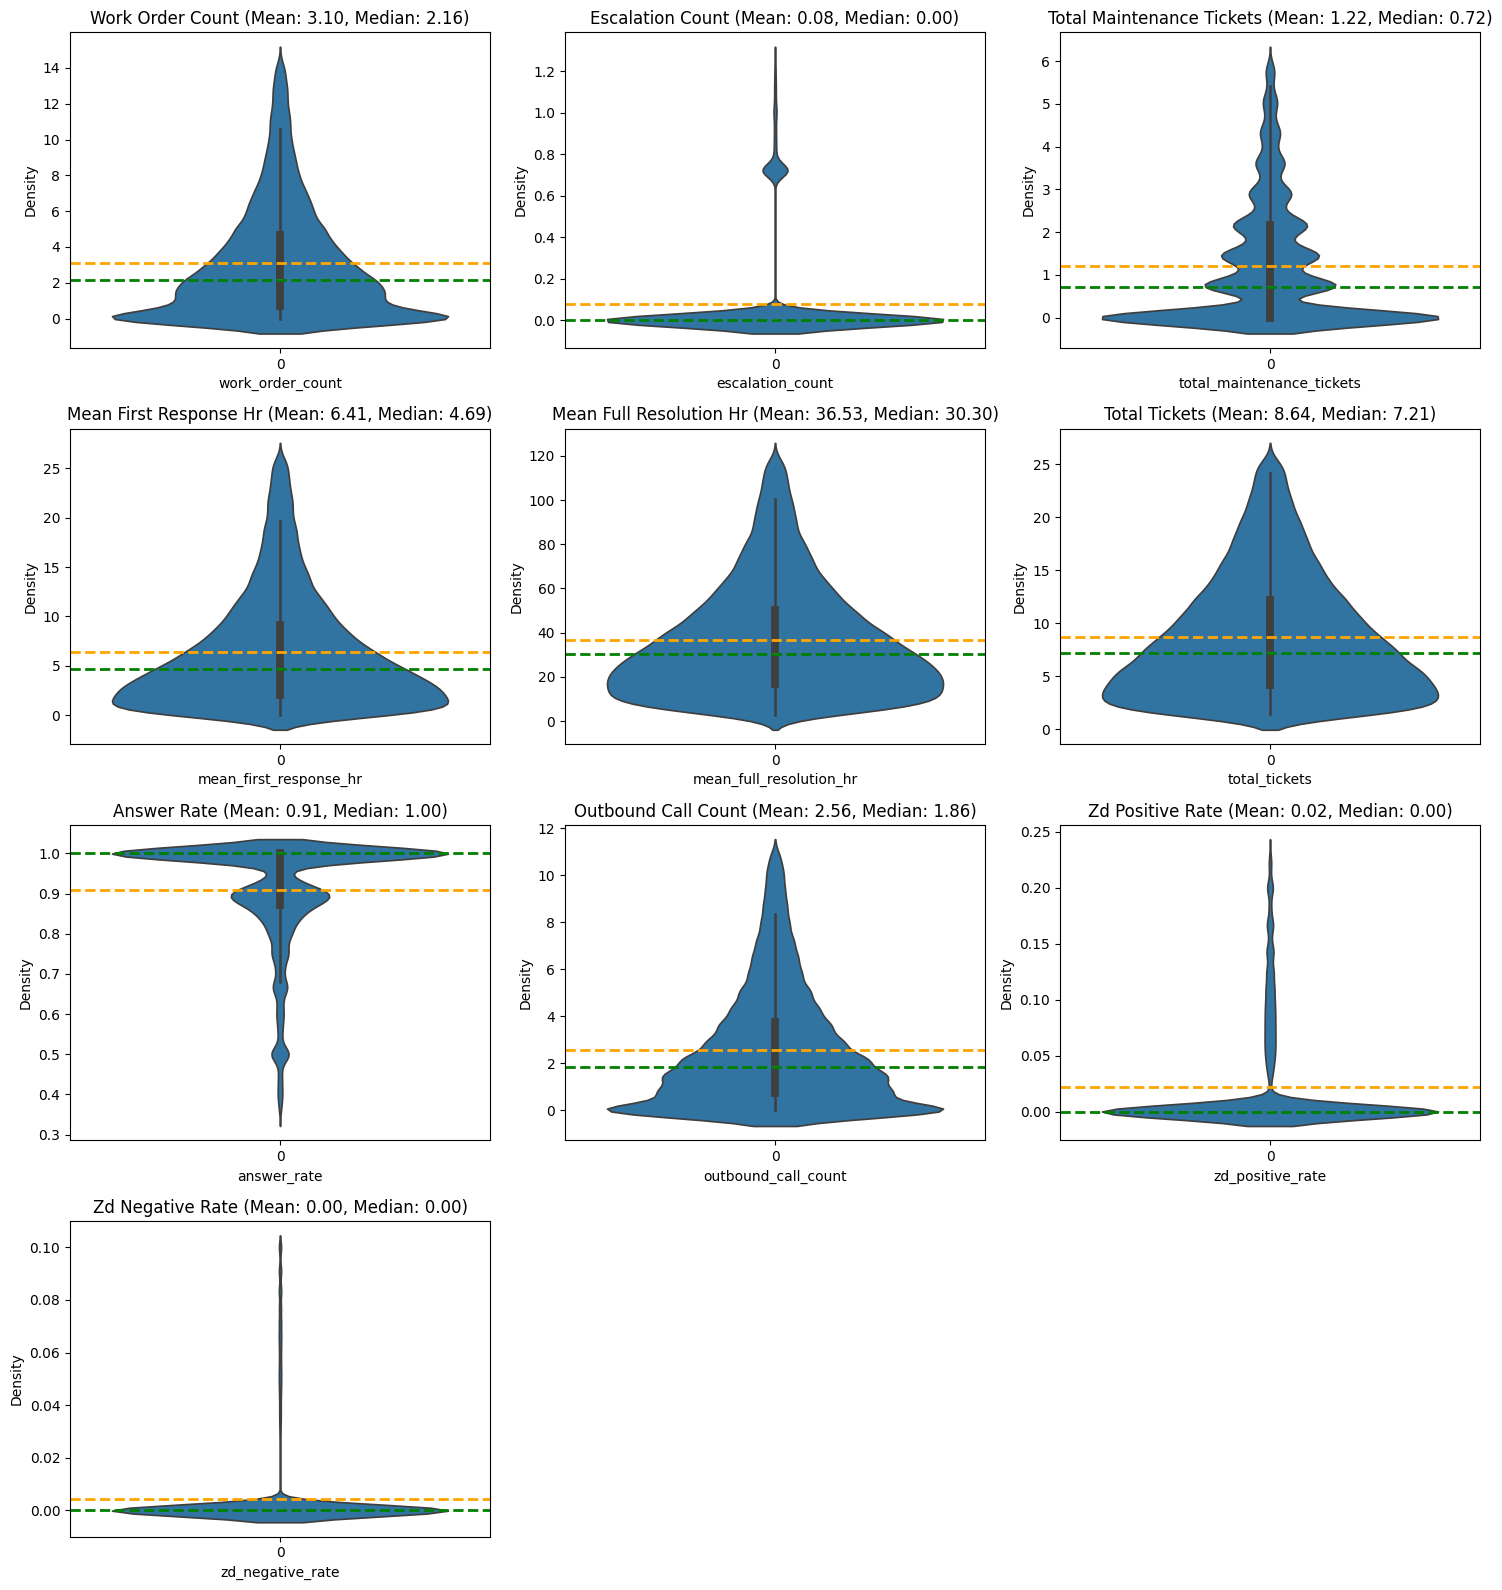

In [5]:
numeric_dict = numerical_data.to_dict(as_series=False)

num_plots = len(numerical_data.columns)
cols = int(np.sqrt(num_plots))
rows = int(np.ceil(num_plots / cols))

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows * 4))
axes = axes.flatten()

for idx, col_name in enumerate(numerical_data.columns):
    # Filtering for the middle 90% of the data
    col_values = numerical_data[col_name]
    lower_quantile = col_values.quantile(0.05)
    upper_quantile = col_values.quantile(0.95)

    # Selecting only the column for easier plotting and calculations
    filtered_values = numerical_data.filter(
        (numerical_data[col_name] >= lower_quantile)
        & (numerical_data[col_name] <= upper_quantile)
    ).select(pl.col(col_name))

    # Converting Polars Series to a numpy array for plotting
    filtered_values_np = filtered_values.to_numpy()

    ax = axes[idx]
    sns.violinplot(data=filtered_values_np, ax=ax)

    mean_val = np.mean(filtered_values_np)
    median_val = np.median(filtered_values_np)

    ax.axhline(mean_val, color="orange", linestyle="dashed", linewidth=2, label="Mean")
    ax.axhline(
        median_val, color="green", linestyle="dashed", linewidth=2, label="Median"
    )

    ax.set_title(
        f"{col_name.replace('_', ' ').title()} (Mean: {mean_val:.2f}, Median: {median_val:.2f})"
    )
    ax.set_xlabel(col_name)
    ax.set_ylabel("Density")

# Hiding unused subplots if any
for idx in range(num_plots, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

## PCA

Apply PCA to help understand the contribution of each feature to the variance structure of the data matrix. Features that do not contribute significantly to the principal components can be considered low-signal.

In [6]:
pca_pipeline = Pipeline(
    [
        (
            "scaler",
            RobustScaler(
                with_centering=True,
                with_scaling=True,
            ),
        ),
        ("pca", PCA()),
    ]
)

pca_pipeline

Pipeline(steps=[('scaler', RobustScaler()), ('pca', PCA())])

In [7]:
pca_pipeline.fit(numerical_data)

Pipeline(steps=[('scaler', RobustScaler()), ('pca', PCA())])

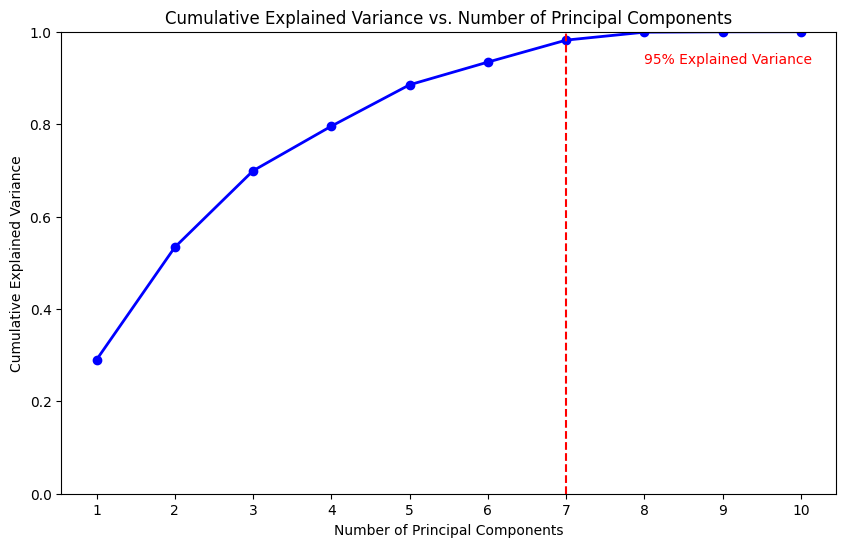

In [8]:
cum_exp_var = np.cumsum(pca_pipeline.named_steps["pca"].explained_variance_ratio_)
pc_indices = np.arange(1, pca_pipeline.named_steps["pca"].n_components_ + 1)
cum_exp_var_95 = np.argmax(cum_exp_var >= 0.95) + 1

plt.figure(figsize=(10, 6))
plt.plot(pc_indices, cum_exp_var, color="blue", marker="o", linestyle="-", linewidth=2)
plt.ylim(0, 1)
plt.xticks(pc_indices)
plt.axvline(cum_exp_var_95, color="red", linestyle="--")
plt.text(
    cum_exp_var_95 + 1,
    cum_exp_var[cum_exp_var_95 - 1] - 0.05,
    "95% Explained Variance",
    color="red",
)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance vs. Number of Principal Components")
plt.show()

### Loadings

In [9]:
loadings = pca_pipeline.named_steps["pca"].components_

loadings_data = pl.DataFrame(loadings)
loadings_data.columns = pca_pipeline.named_steps["scaler"].feature_names_in_
loadings_data = loadings_data.with_columns(
    pl.Series("pc", range(1, len(loadings_data) + 1))
)
loadings_data = loadings_data.select(["pc"] + list(numerical_data.columns))

loadings_data

pc,work_order_count,escalation_count,total_maintenance_tickets,mean_first_response_hr,mean_full_resolution_hr,total_tickets,answer_rate,outbound_call_count,zd_positive_rate,zd_negative_rate
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,0.572469,0.148327,0.402243,0.008435,0.116887,0.289875,-0.315717,0.53948,0.000491,0.000893
2,-0.02407,0.005252,0.019886,0.863374,0.478856,-0.11799,-0.061848,-0.080777,-0.002111,0.001792
3,0.285453,0.017359,0.169878,0.1766,-0.144079,0.210208,0.890627,0.002378,0.000313,0.000587
4,-0.483855,-0.035302,-0.24402,0.299449,-0.351877,0.505111,-0.034502,0.485054,-0.00024,-0.001008
5,-0.282717,0.017569,-0.117708,-0.362239,0.767093,0.155451,0.27116,0.297562,-0.004493,0.001913
6,0.330082,-0.11475,-0.430292,-0.025781,0.14617,0.656308,-0.14638,-0.467464,0.001087,-0.002275
7,-0.399048,-0.058892,0.737898,-0.042033,0.045256,0.3784,-0.084363,-0.37239,0.001949,0.001596
8,-0.089302,0.979505,-0.076774,0.002702,-0.024319,0.068067,0.004025,-0.146307,0.00191,0.006606
9,-0.001228,-0.00158,-0.001605,0.000317,0.004176,-0.001222,0.001278,0.00253,0.999959,-0.00693


Compute the sum of the absolute values of loadings for each feature across the top components that explain 95% of the variance. Features with low aggregate contributions across these components may be considered "low-significance".

In [10]:
feature_contributions = (
    loadings_data.filter(pl.col("pc") <= cum_exp_var_95)
    .drop("pc")
    .select([pl.all().abs()])
    .sum()
)
feature_contributions

work_order_count,escalation_count,total_maintenance_tickets,mean_first_response_hr,mean_full_resolution_hr,total_tickets,answer_rate,outbound_call_count,zd_positive_rate,zd_negative_rate
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.377694,0.39745,2.121925,1.777911,2.050217,2.313343,1.804596,2.245106,0.010684,0.010065


Calculate the 10th percentile (bottom 10%) of the values across all feature columns:

In [11]:
low_contribution_threshold = pl.Series(feature_contributions.row(0)).quantile(0.1)

low_contributing_features = feature_contributions.select(
    [
        pl.col(column)
        for column in feature_contributions.columns
        if feature_contributions[column][0] <= low_contribution_threshold
    ]
).columns

low_contributing_features, low_contribution_threshold

(['zd_positive_rate', 'zd_negative_rate'], 0.010684452586885971)

## Remove Low Contribution Features

In [12]:
data_wo_low_feat_removed = data.drop(low_contributing_features)

numerical_data = data_wo_low_feat_removed.select(pl.exclude("household_id"))

numerical_data

work_order_count,escalation_count,total_maintenance_tickets,mean_first_response_hr,mean_full_resolution_hr,total_tickets,answer_rate,outbound_call_count
f64,f64,f64,f64,f64,f64,f64,f64
5.049407,0.0,2.164032,7.845455,29.825758,5.049407,1.0,0.721344
7.934783,0.0,5.049407,1.216667,28.598374,15.148221,0.540541,11.541502
0.721344,0.0,1.442688,1.35,108.925,3.606719,1.0,1.442688
0.0,0.0,1.442688,2.34,30.948889,6.492095,1.0,2.164032
7.213439,0.0,0.0,15.742308,25.578205,7.934783,1.0,0.0
…,…,…,…,…,…,…,…
20.56338,0.0,7.711268,2.495238,19.987302,38.556338,1.0,7.711268
35.0,5.0,12.5,10.300758,62.044444,20.0,0.866667,15.0
12.762238,0.0,2.552448,1.529412,90.928431,35.734266,1.0,2.552448


## Clustering

### Number of Clusters

In [13]:
num_clusters = np.arange(2, 5)
ch_scores = np.zeros(len(num_clusters))

scaled_data = RobustScaler().fit_transform(numerical_data)
for i, n in tqdm(enumerate(num_clusters)):
    cluster_model = AgglomerativeClustering(n_clusters=n, linkage="average")
    cluster_labels = cluster_model.fit_predict(scaled_data)
    ch_scores[i] = calinski_harabasz_score(scaled_data, cluster_labels)

3it [02:13, 44.57s/it]


Higher Calinski-Harabasz index corresponds to a model with better defined clusters:

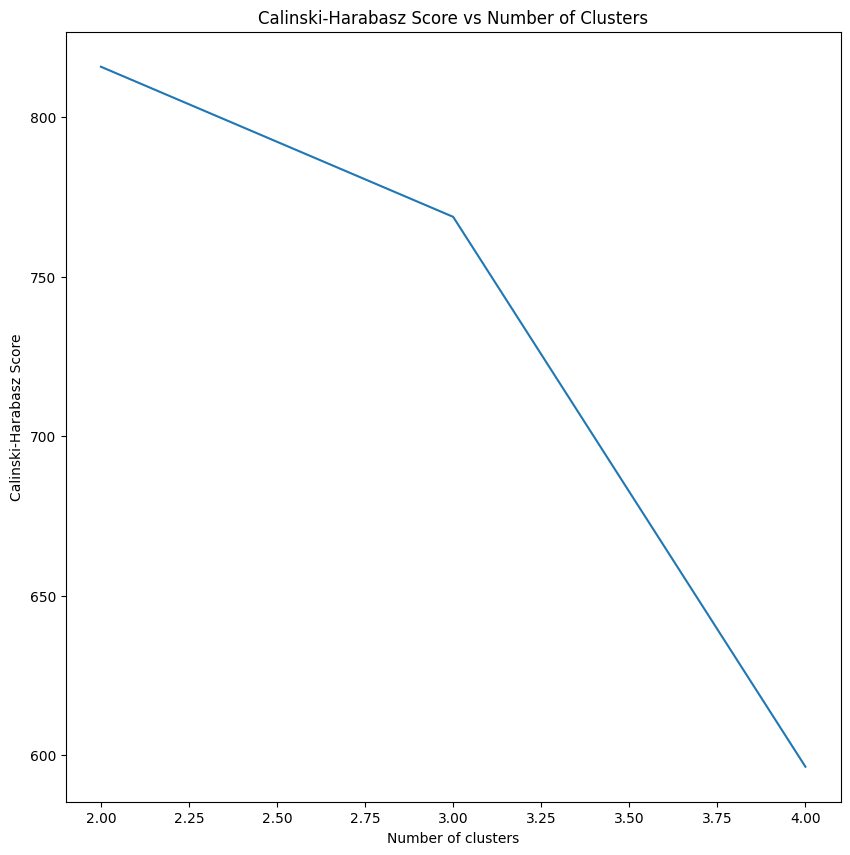

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.plot(num_clusters, ch_scores)
plt.xlabel("Number of clusters")
plt.ylabel("Calinski-Harabasz Score")
plt.title("Calinski-Harabasz Score vs Number of Clusters")
plt.show()

### Linkage Criterion

In [15]:
linkage_criteria = ["ward", "complete", "average", "single"]
ch_scores = np.zeros(len(linkage_criteria))

for i, linkage in tqdm(enumerate(linkage_criteria)):
    model = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    labels = model.fit_predict(scaled_data)
    ch_scores[i] = calinski_harabasz_score(scaled_data, labels)

3it [02:21, 47.09s/it]

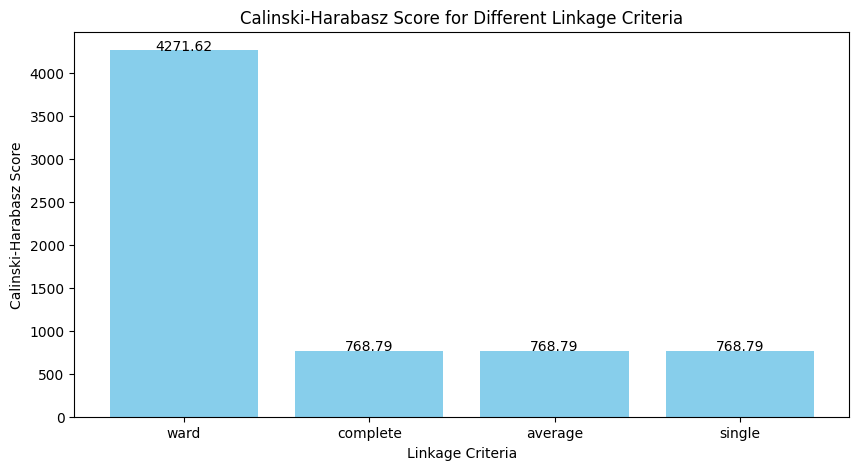

In [ ]:
# Plot the ch scores for different clustering linkage criteria
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.bar(linkage_criteria, ch_scores, color="skyblue")
plt.xlabel("Linkage Criteria")
# Add scores on top of the bars
for i, score in enumerate(ch_scores):
    plt.text(i, score + 0.01, f"{score:.2f}", ha="center")
plt.ylabel("Calinski-Harabasz Score")
plt.title("Calinski-Harabasz Score for Different Linkage Criteria")
plt.show()

### Final Cluster Model

In [13]:
pipelines = {}

for name, n_clusters in tqdm(zip(["two_clusters", "three_clusters"], [2, 3])):
    pipelines[name] = Pipeline(
        [
            ("scaler", RobustScaler(with_centering=True, with_scaling=True)),
            ("cluster", AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")),
        ]
    )
    pipelines[name].fit(numerical_data)

2it [01:54, 57.19s/it]


### Cluster Analysis

In [14]:
cluster_data = data_wo_low_feat_removed.with_columns(
    pl.Series(pipelines["two_clusters"].named_steps["cluster"].labels_).alias(
        "two_clusters"
    ),
    pl.Series(pipelines["three_clusters"].named_steps["cluster"].labels_).alias(
        "three_clusters"
    ),
)

cluster_data

household_id,work_order_count,escalation_count,total_maintenance_tickets,mean_first_response_hr,mean_full_resolution_hr,total_tickets,answer_rate,outbound_call_count,two_clusters,three_clusters
str,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
"""U00000052""",5.049407,0.0,2.164032,7.845455,29.825758,5.049407,1.0,0.721344,1,0
"""U00000080""",7.934783,0.0,5.049407,1.216667,28.598374,15.148221,0.540541,11.541502,0,2
"""U0000008D""",0.721344,0.0,1.442688,1.35,108.925,3.606719,1.0,1.442688,1,0
"""U00000096""",0.0,0.0,1.442688,2.34,30.948889,6.492095,1.0,2.164032,1,0
"""U000000A1""",7.213439,0.0,0.0,15.742308,25.578205,7.934783,1.0,0.0,1,0
…,…,…,…,…,…,…,…,…,…,…
"""U0001671D""",20.56338,0.0,7.711268,2.495238,19.987302,38.556338,1.0,7.711268,0,1
"""U00016724""",35.0,5.0,12.5,10.300758,62.044444,20.0,0.866667,15.0,0,1
"""U0001672E""",12.762238,0.0,2.552448,1.529412,90.928431,35.734266,1.0,2.552448,1,0


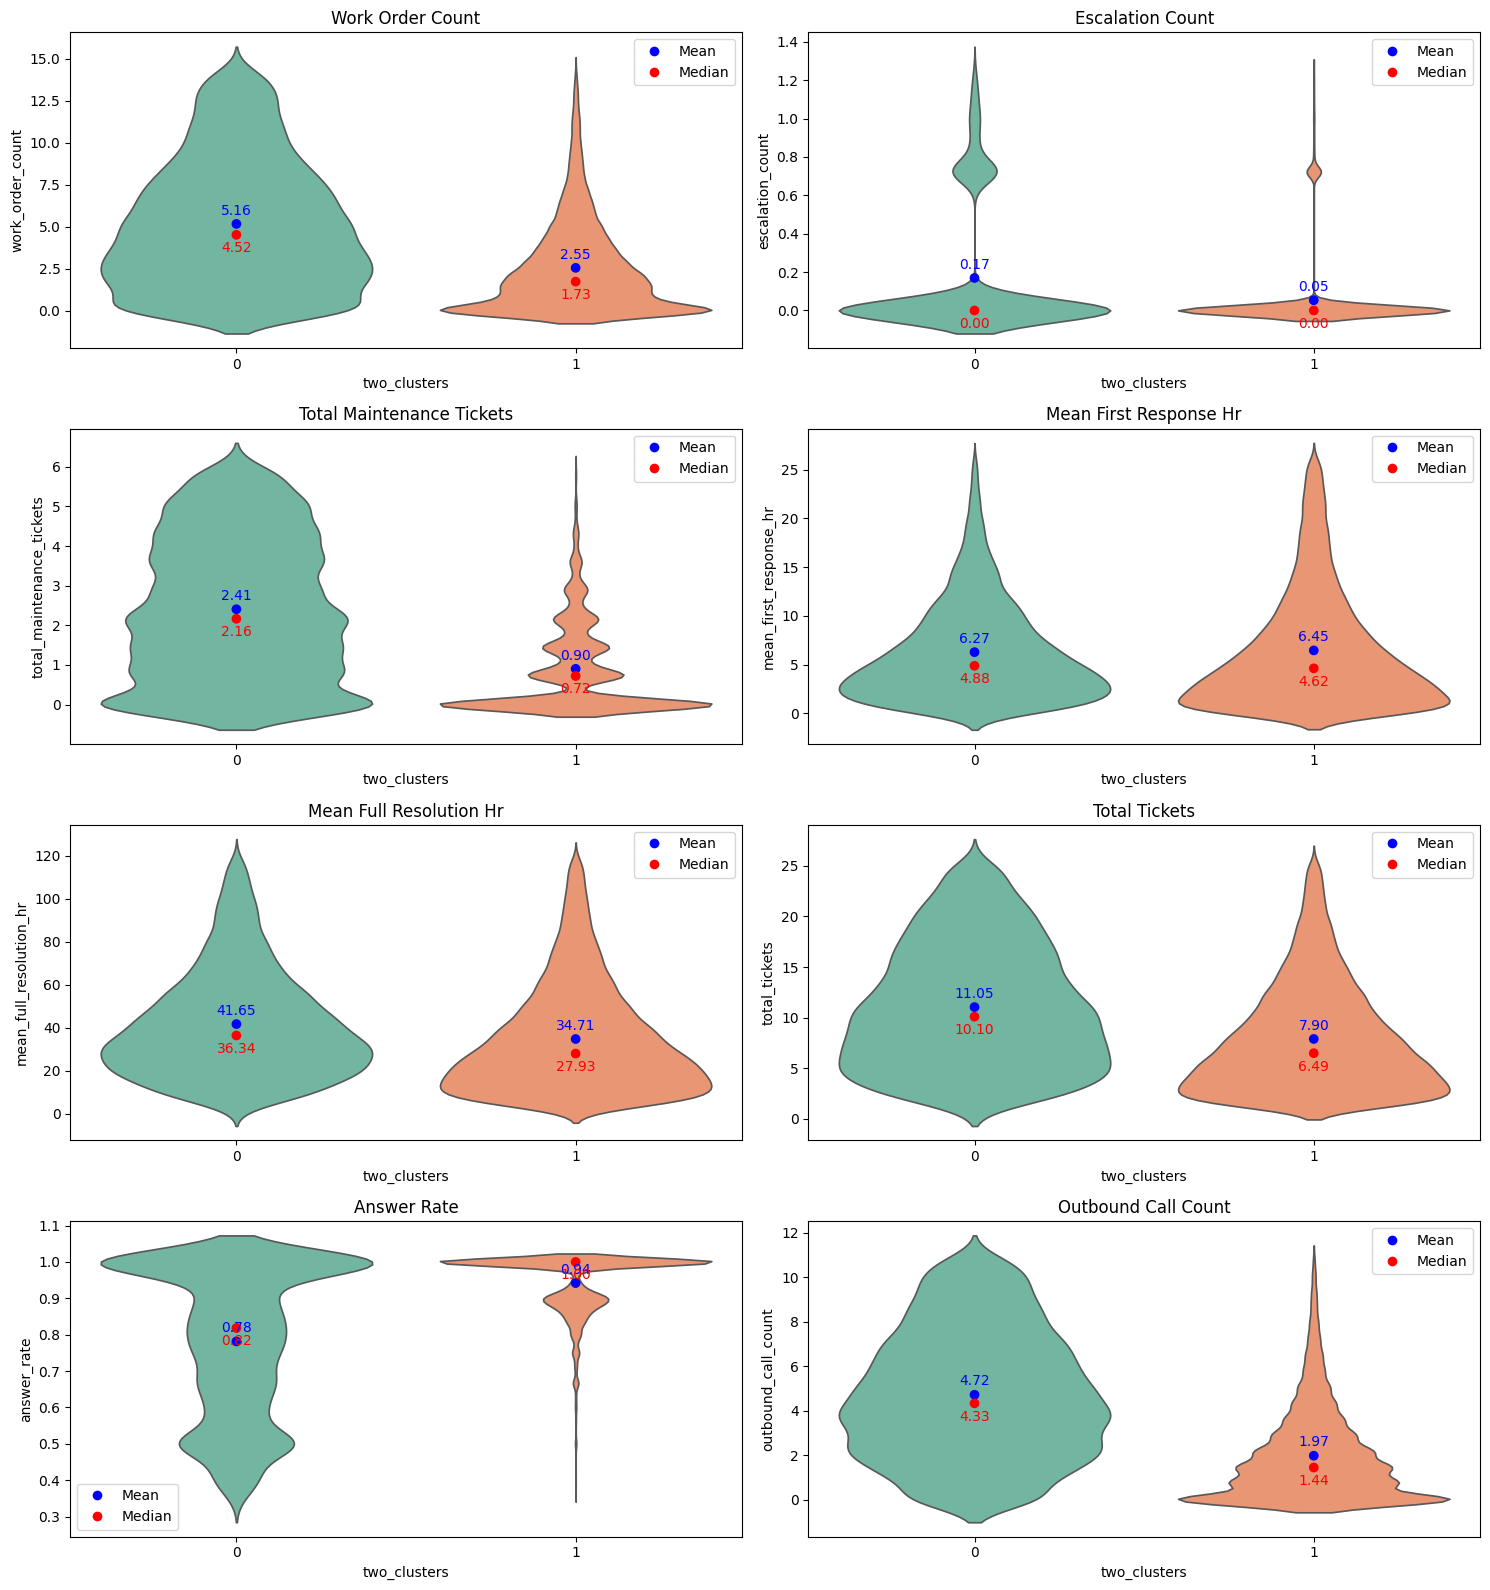

In [48]:
plot_violin_plots(
    cluster_data=cluster_data.drop(["household_id", "three_clusters"]),
    cluster_label="two_clusters",
)

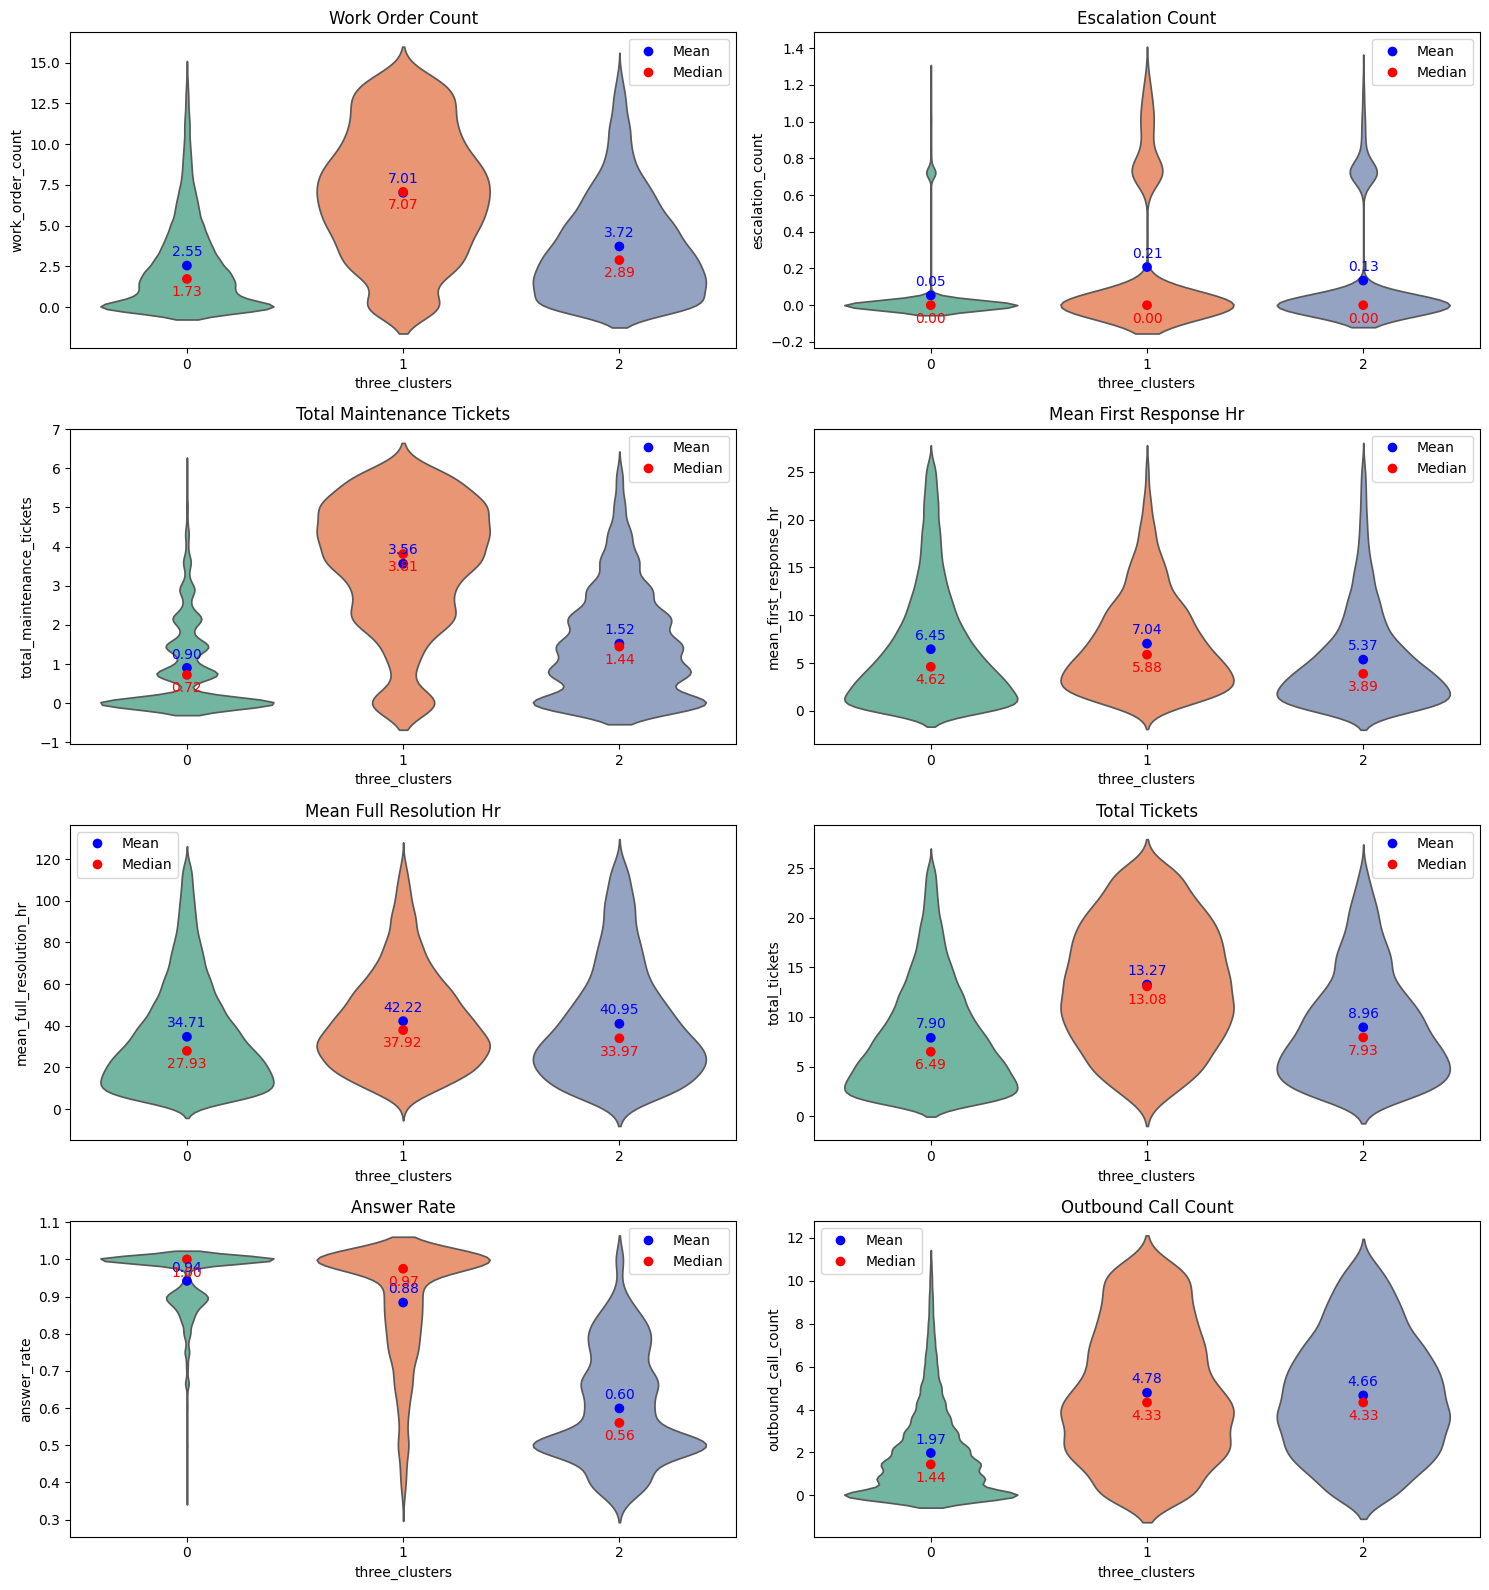

In [49]:
plot_violin_plots(
    cluster_data=cluster_data.drop(["household_id", "two_clusters"]),
    cluster_label="three_clusters",
)

### Assign Cluster Labels

Assigned readable cluster labels based on group statistics:

In [15]:
three_clusters_analysis = (
    cluster_data.drop(["household_id", "two_clusters"])
    .to_pandas()
    .groupby("three_clusters")
    .agg(["mean", "median"])
)

slider = widgets.IntSlider(
    min=0,
    max=len(three_clusters_analysis.columns) - 1,
    step=1,
    value=0,
    description="Columns",
)
slider_end = widgets.IntSlider(
    min=0,
    max=len(three_clusters_analysis.columns) - 1,
    step=1,
    value=20,
    description="End Columns",
)

widgets.interactive(
    lambda start, end: display(three_clusters_analysis.iloc[:, start:end]),
    start=slider,
    end=slider_end,
)

interactive(children=(IntSlider(value=0, description='Columns', max=15), IntSlider(value=15, description='End …

In [16]:
two_clusters_analysis = (
    cluster_data.drop(["household_id", "three_clusters"])
    .to_pandas()
    .groupby("two_clusters")
    .agg(["mean", "median"])
)

slider = widgets.IntSlider(
    min=0,
    max=len(two_clusters_analysis.columns) - 1,
    step=1,
    value=0,
    description="Columns",
)
slider_end = widgets.IntSlider(
    min=0,
    max=len(two_clusters_analysis.columns) - 1,
    step=1,
    value=20,
    description="End Columns",
)

widgets.interactive(
    lambda start, end: display(two_clusters_analysis.iloc[:, start:end]),
    start=slider,
    end=slider_end,
)

interactive(children=(IntSlider(value=0, description='Columns', max=15), IntSlider(value=15, description='End …

In [17]:
cluster_data = cluster_data.with_columns(
    pl.col("two_clusters")
    .replace_strict(
        old=[0, 1], new=["bad_experience", "good_experience"], default="unknown"
    )
    .cast(pl.Categorical)
    .alias("two_clusters"),
    pl.col("three_clusters")
    .replace_strict(
        old=[0, 1, 2],
        new=["good_experience", "opportunity_experience", "bad_experience"],
        default="unknown",
    )
    .cast(pl.Categorical)
    .alias("three_clusters"),
)

cluster_data

household_id,work_order_count,escalation_count,total_maintenance_tickets,mean_first_response_hr,mean_full_resolution_hr,total_tickets,answer_rate,outbound_call_count,two_clusters,three_clusters
str,f64,f64,f64,f64,f64,f64,f64,f64,cat,cat
"""U00000052""",5.049407,0.0,2.164032,7.845455,29.825758,5.049407,1.0,0.721344,"""good_experience""","""good_experience"""
"""U00000080""",7.934783,0.0,5.049407,1.216667,28.598374,15.148221,0.540541,11.541502,"""bad_experience""","""bad_experience"""
"""U0000008D""",0.721344,0.0,1.442688,1.35,108.925,3.606719,1.0,1.442688,"""good_experience""","""good_experience"""
"""U00000096""",0.0,0.0,1.442688,2.34,30.948889,6.492095,1.0,2.164032,"""good_experience""","""good_experience"""
"""U000000A1""",7.213439,0.0,0.0,15.742308,25.578205,7.934783,1.0,0.0,"""good_experience""","""good_experience"""
…,…,…,…,…,…,…,…,…,…,…
"""U0001671D""",20.56338,0.0,7.711268,2.495238,19.987302,38.556338,1.0,7.711268,"""bad_experience""","""opportunity_experience"""
"""U00016724""",35.0,5.0,12.5,10.300758,62.044444,20.0,0.866667,15.0,"""bad_experience""","""opportunity_experience"""
"""U0001672E""",12.762238,0.0,2.552448,1.529412,90.928431,35.734266,1.0,2.552448,"""good_experience""","""good_experience"""


### Confusion Matrix 

Analyzes the transition of samples when going from three clusters to two clusters and plots the resulting confusion matrix.

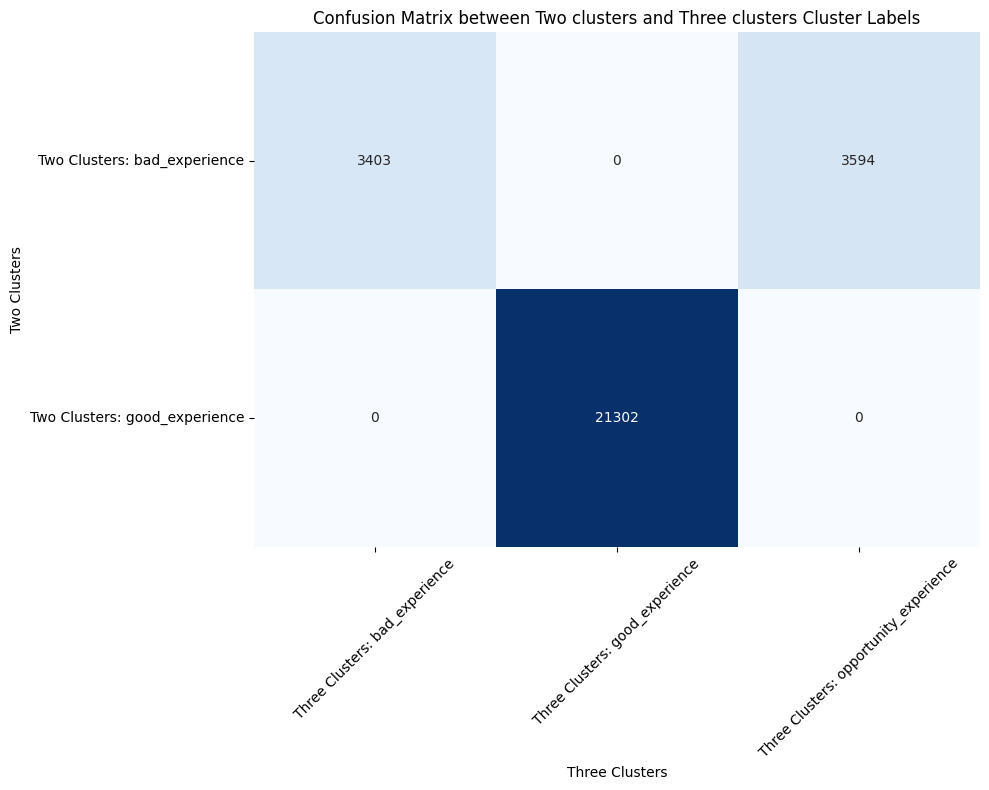

In [18]:
plot_confusion_matrix(
    x_cluster_labels=cluster_data["three_clusters"].to_pandas(),
    y_cluster_labels=cluster_data["two_clusters"].to_pandas(),
    x_label="Three Clusters",
    y_label="Two Clusters",
    figsize=(10, 8),
)

## Upload Data & Model

In [19]:
fs = s3fs.S3FileSystem()
with fs.open(
    f"s3://{config['s3_bucket']}/{config['s3_key']}/input-data/cluster/cluster_data.parquet",
    mode="wb",
) as f:
    cluster_data.drop("three_clusters").rename(
        {"two_clusters": "clusters"}
    ).write_parquet(f)

In [20]:
with fs.open(
    f"s3://{config['s3_bucket']}/{config['s3_key']}/models/cluster_pipeline.joblib",
    "wb",
) as f:
    dump(pipelines["two_clusters"], f)